<a href="https://colab.research.google.com/github/FathimaNazarudeen/emotion-recgntn/blob/main/mfcczcr_tcn_feature_extraction_classi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

In [ ]:
!pip install keras-tcn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tcn import TCN
from keras.utils import to_categorical



In [ ]:
# Load CSV dataset
df = pd.read_csv('/kaggle/input/mfcczcrconcatenated/mfcczcr.csv')
print(df.shape[1]) # print the number of columns in the DataFrame


82


In [ ]:
df.shape

(12162, 82)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tcn import TCN
from keras.utils import to_categorical

# Load CSV dataset
df = pd.read_csv('/kaggle/input/mfcczcrconcatenated/mfcczcr.csv')

# Split input features and class label
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Convert string class labels to integer labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standardize input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape input features to 3D array
X = X.reshape(-1, 1, 81)


# Get the number of classes in the y array
n_classes = len(np.unique(y))

# Convert class labels to one-hot encoded vectors
y_one_hot = to_categorical(y, num_classes=n_classes)

# Define TCN model
inputs = Input(shape=(X.shape[1], X.shape[2]))
x = TCN(nb_filters=128, kernel_size=6, dilations=[1,2,4,8,16,32,64,128], return_sequences=False)(inputs)
x = Dense(14, activation='softmax')(x)  # Add a dense layer with 14 units and softmax activation
model = Model(inputs, x)

# Compile and fit TCN model
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.fit(X, y_one_hot, epochs=50, batch_size=32)

# Extract high-level features
feature_model = Model(inputs=model.input, outputs=model.layers[-2].output)
high_level_features = feature_model.predict(X)

# Add column names to high-level features DataFrame
col_names = [f'feature_{i+1}' for i in range(high_level_features.shape[1])]
df_high_level = pd.DataFrame(high_level_features, columns=col_names)

# Add class column to high-level features DataFrame
df_high_level['class'] = label_encoder.inverse_transform(y)

# Save high-level features to CSV
df_high_level.to_csv('high_level_featuresmfcczcr.csv', index=False)

Epoch 1/50
381/381 [==============================] - 21s 20ms/step - loss: 1.3972
Epoch 2/50
381/381 [==============================] - 8s 21ms/step - loss: 1.0742
Epoch 3/50
381/381 [==============================] - 8s 20ms/step - loss: 0.9604
Epoch 4/50
381/381 [==============================] - 8s 20ms/step - loss: 0.8834
Epoch 5/50
381/381 [==============================] - 8s 20ms/step - loss: 0.8096
Epoch 6/50
381/381 [==============================] - 8s 21ms/step - loss: 0.7522
Epoch 7/50
381/381 [==============================] - 8s 20ms/step - loss: 0.6925
Epoch 8/50
381/381 [==============================] - 8s 20ms/step - loss: 0.6465
Epoch 9/50
381/381 [==============================] - 8s 20ms/step - loss: 0.5815
Epoch 10/50
381/381 [==============================] - 8s 20ms/step - loss: 0.5408
Epoch 11/50
381/381 [==============================] - 8s 20ms/step - loss: 0.4921
Epoch 12/50
381/381 [==============================] - 8s 20ms/step - loss: 0.4362
Epoch 13/50


In [ ]:
from sklearn.metrics import f1_score
from sklearn import metrics

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tcn import TCN

# Load dataset
df = pd.read_csv('high_level_featuresmfcczcr.csv')

# Split input features and class label
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Convert string class labels to integer labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standardize input features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input features to 3D array
X = X.reshape(-1, 1, X.shape[1])

# One-hot encode class labels
num_classes = 14
y = to_categorical(y, num_classes)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Build TCN model
model = Sequential()
model.add(TCN(nb_filters=64, kernel_size=6, dilations=[1, 2, 4, 8, 16, 32, 64], 
              return_sequences=False, activation='relu', use_batch_norm=True))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history= model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print("Validation loss:", loss)
print("Validation accuracy:", accuracy)

# Predict class labels for test set
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)

# Calculate F1 score

f1 = metrics.f1_score(np.argmax(y_test, axis=1), y_pred_class, average='macro')

print("F1 score:", f1)

Epoch 1/50
153/153 [==============================] - 19s 42ms/step - loss: 2.2193 - accuracy: 0.5179 - val_loss: 2.1554 - val_accuracy: 0.3683
Epoch 2/50
153/153 [==============================] - 6s 37ms/step - loss: 0.6362 - accuracy: 0.8172 - val_loss: 0.9182 - val_accuracy: 0.7764
Epoch 3/50
153/153 [==============================] - 6s 38ms/step - loss: 0.4163 - accuracy: 0.8820 - val_loss: 0.2310 - val_accuracy: 0.9301
Epoch 4/50
153/153 [==============================] - 6s 37ms/step - loss: 0.3232 - accuracy: 0.9116 - val_loss: 0.1709 - val_accuracy: 0.9478
Epoch 5/50
153/153 [==============================] - 6s 38ms/step - loss: 0.2760 - accuracy: 0.9257 - val_loss: 0.1376 - val_accuracy: 0.9560
Epoch 6/50
153/153 [==============================] - 6s 36ms/step - loss: 0.2255 - accuracy: 0.9373 - val_loss: 0.1364 - val_accuracy: 0.9614
Epoch 7/50
153/153 [==============================] - 6s 37ms/step - loss: 0.2082 - accuracy: 0.9415 - val_loss: 0.1240 - val_accuracy: 0.966

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

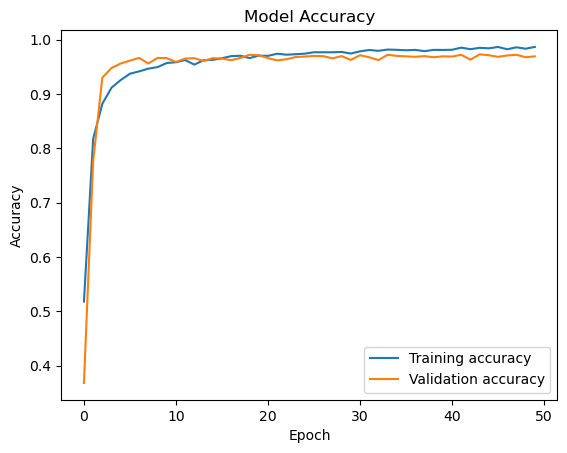

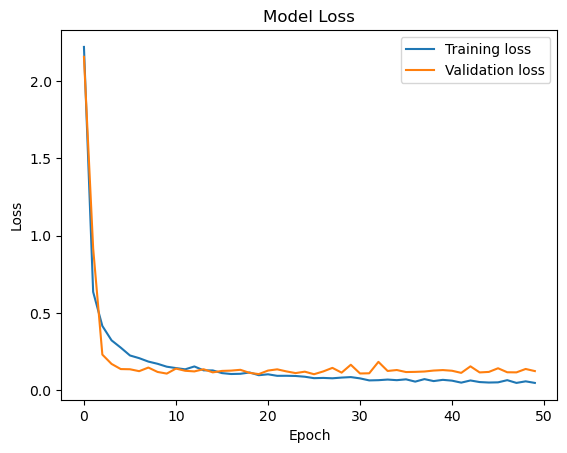

In [ ]:
# Plot accuracy and loss over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


77/77 [==============================] - 0s 5ms/step


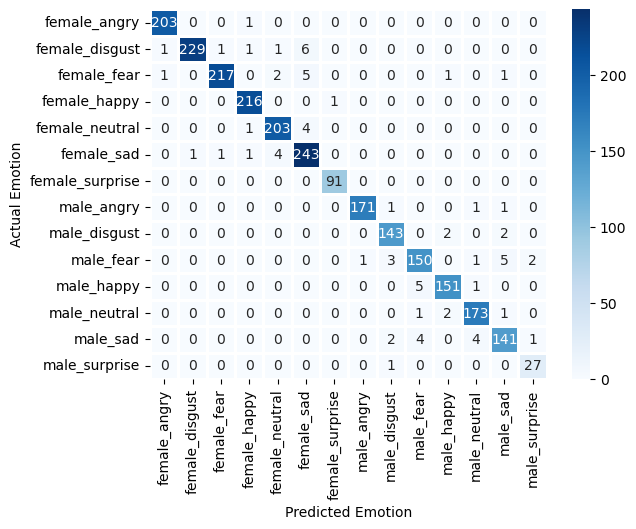

In [ ]:
# Get the true and predicted labels
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Set the tick labels to the emotion names
tick_labels = label_encoder.classes_

# Plot the confusion matrix
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='',
            xticklabels=tick_labels, yticklabels=tick_labels)

# Add labels to the plot
plt.xlabel('Predicted Emotion')
plt.ylabel('Actual Emotion')
plt.show()

In [ ]:
# Get the true and predicted labels
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

# Get the classification report
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

77/77 [==============================] - 0s 5ms/step
                 precision    recall  f1-score   support

   female_angry       0.99      1.00      0.99       204
 female_disgust       1.00      0.96      0.98       239
    female_fear       0.99      0.96      0.97       227
   female_happy       0.98      1.00      0.99       217
 female_neutral       0.97      0.98      0.97       208
     female_sad       0.94      0.97      0.96       250
female_surprise       0.99      1.00      0.99        91
     male_angry       0.99      0.98      0.99       174
   male_disgust       0.95      0.97      0.96       147
      male_fear       0.94      0.93      0.93       162
     male_happy       0.97      0.96      0.96       157
   male_neutral       0.96      0.98      0.97       177
       male_sad       0.93      0.93      0.93       152
  male_surprise       0.90      0.96      0.93        28

       accuracy                           0.97      2433
      macro avg       0.96      0